In [347]:
import numpy as np
import scipy.stats as stats
import msprime
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
import pandas as pd

The variance in $\pi$ is:

$$\text{Var}(\pi) = \frac{n + 1}{3(n-1)} \theta + \frac{2(n^2 + n + 3)}{9n(n-1)}\theta^2$$

In the limit as $n \to \infty$, $\text{Var} = \frac{1}{9}(3 \theta + 2 \theta^2)$. The first term is the sampling variation, the second is the evolutionary variation. 

Does this theory check out?

In [268]:
N = 1000
ns = [2, 4, 6, 10, 20, 30, 40] + np.arange(50, N, 100).tolist()

In [273]:
y = [np.var([msprime.sim_ancestry(n, population_size=N).diversity(mode='branch')/(4*N) for _ in range(1000)]) for n in ns]

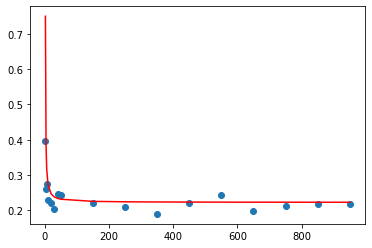

In [274]:
def taj85_var(n, theta):
    return (n+1)/(3*(n-1))*theta + 2*(n**2 + n + 3)/(9*n*(n-1)) * theta**2
plt.scatter(ns, y)
plt.plot(ns, taj85_var(np.array(ns), 1/2), c='r')

If we're using branch statistics, our only source of variation is evolutionary variation. The pairwise coalescent time $T_2 \sim \text{Exp}(1/2N)$, such that $\text{E}(T_2) = 2N$ and $\text{Var}(T_2) = 4N^2$.

## Estimating B

Each run draws $s$ sample trees, calculates $\hat{B}$ for each tree, and average them to get $\bar{B}$. I then consider the variance of these $\bar{B}$s.

In [297]:
N = 1000
B_array = np.linspace(0.1, 1, 10)
s_array = [2, 5, 10, 50, 100]
n_array = [N]
N_array = [N]
rep_array = np.arange(1000)
params = list(itertools.product(B_array, s_array, n_array, N_array, rep_array))
param_grid = np.array(params)

def runner(param):
    B, s, n, N, rep = param
    sims = np.array([msprime.sim_ancestry(n, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(s)])
    return sims.mean(), sims.var()

with Pool(70) as p:
    res = np.array(p.map(runner, params))

In [377]:
d = pd.DataFrame(np.concatenate((param_grid, res[:, 0][:, None]), axis=1))
d.columns = ['B', 's', 'n', 'N', 'rep', 'Bhat']
d.head()

,B,s,n,N,rep,Bhat
0,0.1,2.0,1000.0,1000.0,0.0,0.059737
1,0.1,2.0,1000.0,1000.0,1.0,0.064928
2,0.1,2.0,1000.0,1000.0,2.0,0.108950
3,0.1,2.0,1000.0,1000.0,3.0,0.076978
4,0.1,2.0,1000.0,1000.0,4.0,0.096129


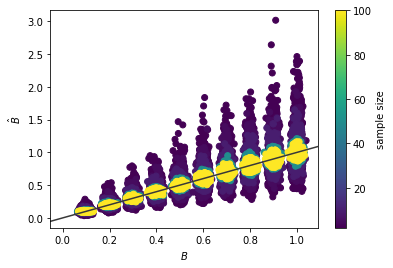

In [455]:
def jitter(x, var=0.01):
    return x + np.random.normal(0, var, len(x))

fig, ax = plt.subplots()
cax = ax.scatter(jitter(d['B']), d['Bhat'], c=d['s'], alpha=1)
ax.axline((0, 0), slope=1, c='0.22')
ax.set_xlabel('$B$')
ax.set_ylabel('$\hat{B}$')
plt.colorbar(cax, label='sample size')

In [395]:
ds = d.groupby(['B', 's', 'n', 'N']).agg([np.mean, np.var]).reset_index()
ds.columns = ["_".join(x) if len(x[1]) > 0 else x[0] for x in ds.columns]
ds.head()

,B,s,n,N,rep_mean,rep_var,Bhat_mean,Bhat_var
0,0.1,2.0,1000.0,1000.0,499.5,83416.666667,0.100114,0.001105
1,0.1,5.0,1000.0,1000.0,499.5,83416.666667,0.099060,0.000447
2,0.1,10.0,1000.0,1000.0,499.5,83416.666667,0.100330,0.000226
3,0.1,50.0,1000.0,1000.0,499.5,83416.666667,0.100451,0.000047
4,0.1,100.0,1000.0,1000.0,499.5,83416.666667,0.099921,0.000021


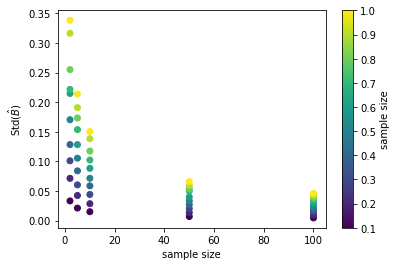

In [451]:
fig, ax = plt.subplots()
cax = ax.scatter(ds['s'], np.sqrt(ds['Bhat_var']), c=ds['B'])
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
plt.colorbar(cax, label='sample size')

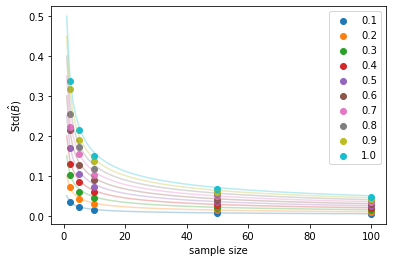

In [452]:
fig, ax = plt.subplots()
sx = np.arange(1, 100)
for b in B_array:
    dx = ds.loc[ds['B'] == b]
    c = ax.scatter(dx['s'], np.sqrt(dx['Bhat_var']), label=np.round(b, 2))
    ax.plot(sx, b*np.sqrt(0.25/sx), alpha=0.3)
ax.set_ylabel("$\mathrm{Std}(\hat{B})$")
ax.set_xlabel("sample size")
ax.legend()

We wish to estimate $\hat{B} = \bar{T}_2/2N$ from simulations. For simplicity, let's assume $\bar{T}_2 = \frac{1}{n} \sum_i^n T_2(i)$, so $\text{var}(\bar{T}_2) = \text{Var}(T_2) / n$.

Then $\text{Var}(\hat{B}) = 4N^2/n4N^2 = 1/n$.

The sum of $n$ exponentials $n\bar{T}_2 = \sum_i^n T_2(i)$, $n\bar{T}_2 \sim \text{Gamma}(n, 1/2BN)$ (shape/rate parameterization).



In [67]:

def gamma_ci(n, N, alpha=0.05):
    rate = 0.5/N
    scale = 1/rate
    v = stats.gamma.ppf((alpha/2, 1-alpha/2), a=n, scale=1)
    return v

gamma_ci(100, 2000)

array([ 81.36399125, 120.52894775])